# Homework 1

### CS328 — Numerical Methods for Visual Computing and Machine Learning
- - -

**Out** on Tuesday 27/09/2022, **due** on Friday 14/10/2022.

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please complete/extend this notebook for your homework submission:

* Begin your response to each problem with a <tt>&nbsp;<b>## Solution</b>&nbsp;&nbsp;</tt> markdown cell.
* In addition to your code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.
* Before handing in, please make sure that your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.anaconda.com/products/individual">Anaconda</a>, specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS328 count towards your final grade and must therefore be done individually.
</div>

### Prelude

The following fragment imports NumPy and Matplotlib and configures the latter to produce nice graphics on modern high-resolution screens. The import statements at the end establish a shorthand notation for the most common integer and floating point formats.

In [952]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import random as rnd
from matplotlib import pyplot as plt

from numpy import uint16  as u16
from numpy import uint32  as u32
from numpy import uint64  as u64
from numpy import float16 as f16
from numpy import float32 as f32
from numpy import float64 as f64

Two more definitions: the helper functions ``f2i`` and ``i2f``  below reinterpret floating point values as an integers and vice versa. We'll use these in Problem 3 to access the bit-level representation of an IEEE 754 floating point value.

In [953]:
def f2i(value):
    ''' Reinterpret floating point value as integer '''
    return value.view('u%i' % value.itemsize)

def i2f(value):
    ''' Reinterpret integer as floating point value '''
    return value.view('f%i' % value.itemsize)

## Problem 1: Images, slicing, and color balancing (15 pts)

The following two lines of code download a portrait photograph from the Wikipedia article on [color balance](https://en.wikipedia.org/wiki/Color_balance) and store it in a single precision NumPy array named ``image``, whose pixels are in the range ``[0.0, 1.0]``.

In [954]:
import PIL, requests
image = np.array(PIL.Image.open(requests.get('https://goo.gl/VcYNGN', stream=True, headers = {'User-agent': 'Mozilla/5.0'}).raw), dtype = np.float32) / 255

Try plotting this image using ``plt.imshow``.

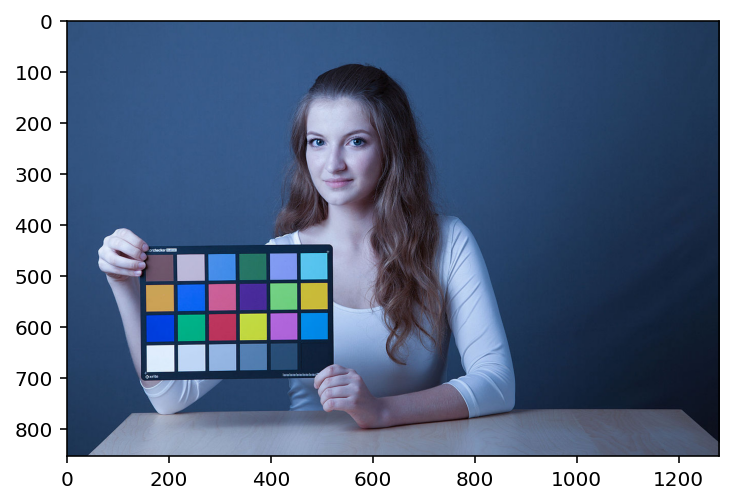

In [955]:
## Solution
plt.imshow(image)

You will notice that the colors are distorted by a strong blue tint. Such intense color casts can lead to unnatural appearance and are usually not desired in portrait photography. In such cases, *color balancing* can be used to post-process the colors of an existing image to e.g. ensure that white objects indeed appear white in the image. One of the simplest kinds of color balancing is known as *white balancing*. Here, we select a region of the image that is known to contain a neutral color, and we then determine the reciprocal of the associated red, green, and blue color values. Afterwards, the color channels of the entire image are scaled by these reciprocals, ensuring that the selected region becomes neutral (i.e. it has similar amounts of red, green, and blue).

Note that the woman holds a [color checker](https://en.wikipedia.org/wiki/ColorChecker) in her hands. A color checker consists of an arrangement of colored patches with known color values, and the last row usually contains neutral colors. We will  use the second neutral patch on the bottom left to white-balance this image.

**TODO**: Use NumPy *slicing* operations to crop out the second neutral patch in the last row (counting from the left side) and plot it using ``plt.imshow``. The cropped region should be as large as possible without including the black frame or other patches.

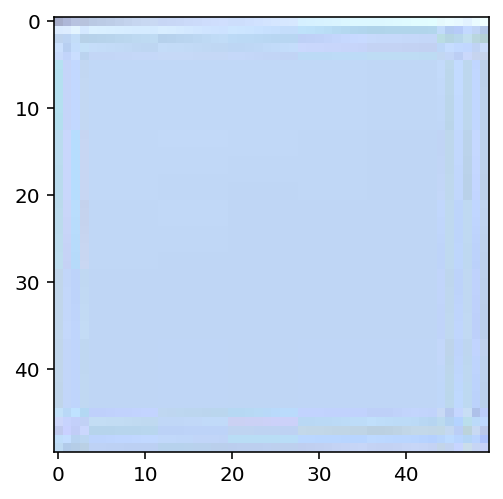

In [956]:
## Solution
patch = image[635:685,220:270,::] # coordinates retrived manually after several trials with 
                                  # different numbers to isolate the color
plt.imshow(patch)

**TODO**: Compute the mean of the R, G, and B color channels over the patch. You should be able to accomplish this with a single function call to ``np.mean``. Print the computed mean using ``print()``.

In [957]:
## Solution
mean_patch = np.mean(patch, axis=(0,1)) # To get the mean of the red, green and blue
                                        # Mean over axis 0 gives a 1x3x3 array
                                        # Then mean over axis 1 gives a 1x1x3 array that is a 1x3
#print(mean_patch)

**TODO**: Now, use *broadcasting* to multiply the image R, G, B channels by the reciprocals (inverses) of the values computed above and visualize the result using ``plt.imshow``. *Note*: You may need to scale the image by a small amount to prevent pixels overflowing to a value greater than ``1.0``, which will lead to strange color artifacts. (Our reference implementation uses a value of ``0.85``.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


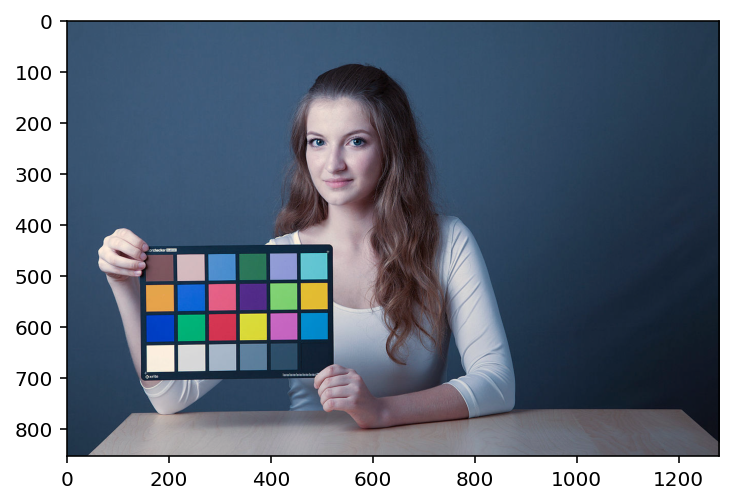

In [958]:
## Solution
image = image*0.85 * np.reciprocal(mean_patch)
plt.imshow(image)

# Problem 2: Triple Birthday Paradox (25 pts)

Let us again consider the [Birthday Paradox](https://en.wikipedia.org/wiki/Birthday_problem) that was introduced during the first week's exercise session. In this task, we will study a slightly modified problem that can be summarized with the following question:

**What is the probability that at least *three* people in a random set of $n$ people share the same birthday?**

In the following, you will develop a simple numerical Python program to solve this problem and then make use of vectorization with NumPy arrays to speed it up. For this reason, you should use the "magic" Jupyter function ```%%time``` to profile the execution time of your implementation at every step.

## Problem 2.1: Basic Python Implementation (10 pts)

**TODO**: Write a basic Python program<a name="myfootnote1"><sup>[1]</sup></a> that estimates of the "3-birthdays probability" based on random sampling. 

Feel free to reuse code from the [first weeks notebook](https://moodle.epfl.ch/mod/resource/view.php?id=1084885) to get some inspiration on how you would do this.
The structure should stay exactly the same:
1. Choose $n$ random birthdays (i.e. integers)
2. Check if *three* of the birthdays are the same
3. Repeat this process $K$ times and keep track of how many times it was true
4. Return the ratio between "number successful events" and "total number events" ($K$)

When you chose $K$ large enough, a simulation like this should give you a good estimate of the true probability.

Remember that you can generate random integers by using *```randint```* from the *```random```* module:

```python
import random as rnd
a = rnd.randint(0, 10) # Random integer between 0 and 10 (including)
```
[[1]](#myfootnote1) Do **not** use any of the NumPy, SciPy, ... libraries in this part of the exercise—only pure Python is allowed.

In [959]:
## TODO... Fill in the inner loop of the following function

# For n people, compute an approximation of the probability that at
# least three people share the same birthday, using K iterations
def birthday_paradox_basic(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        ## Solution
        birthdays = [rnd.randint(1,365) for x in range(n)] # create an array of n random integers from 1 to 365
        success = False
        for b in birthdays: # run through the array of birthdays linearly and verify if the count is greater or equal than 3
            if birthdays.count(b) >= 3:
                success = True
                break       # stop the for loop whenever it encounters an element satisfying the condition
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

To test if your program is operating correctly, try running it for $n=88$ people using a very high value of $K$ (e.g. ``100000``). This should give you (in expectation) a probability slightly above $0.5$:

In [960]:
%%time
## Solution
print(birthday_paradox_basic(88, 100000))

0.51097
CPU times: user 15 s, sys: 564 ms, total: 15.5 s
Wall time: 16.6 s


**TODO**: Finally, profile the running time of the implementation and report how much time it took for $K=100000$. You can do this simply by putting the ["magic command"](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) ``%%time`` at the top of the cell that should be timed:

## Problem 2.2: Vectorized implementation using NumPy (15 pts)

As you likely noticed, an implementation in pure Python is rather slow! As a frame of reference: an implementation with list comprehensions (as was done during the exercise session) can easily take half a minute to complete for large values of $K$ like above. Creating lists of random integers is a particularly slow operation that can be considerably accelerated using vectorized NumPy functions that process entire NumPy arrays at a once.

**TODO**: Write another function that computes the same result, but this time, replace the inner part of the "*```for it in range(K)```*" loop with a combination of NumPy array functions.<a name="myfootnote2"><sup>[2]</sup></a>

Here are a number of NumPy functions that you may find helpful:
* ```np.random.randint```
* ```np.bincount```
* ```np.unique```
* ```np.min, np.max```
* ```np.arange```
* ```np.any```

You can read about these in the [NumPy Documentation](https://numpy.org/doc/stable/).

**Hint**: The output range of ```np.random.randint``` differs slightly from ```random.randint``` provided by the standard library that you used above. Make sure not to introduce any subtle off-by-one errors!

[[2]](#myfootnote2) In this part of the exercise, do **not** use Python lists and list comprehensions, and do not explicitly iterate over the days of the year. Do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.

In [961]:
## TODO... Fill in the inner loop of the following function

def birthday_paradox_numpy(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        ## Solution
        birthdays = np.random.randint(1, 366, size=n) # create an array of n random integers from 1 to 365
        birthdays_count = np.bincount(birthdays) # count the occurences of each integers in the previous array
        is_condition = birthdays_count >= 3 # create an array telling for each count if the value is greater or equal than 3
        success = np.any(is_condition) # is true if there is at least one true element in the array 'is_condition'
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

**TODO**: Profile the running time of the implementation vectorized implementation for $K=100000$ like above and report the (approximate) speedup in a markdown cell or comment.

In [962]:
%%time
## Solution
print(birthday_paradox_numpy(88, 100000))

0.50947
CPU times: user 2.38 s, sys: 85.6 ms, total: 2.47 s
Wall time: 2.61 s


## Problem 2.3: Optional Exercise (0 points, not graded)
-- --
<br/>Although the vectorized implementation is a tremendous improvement, it still contains a loop over a potentially large number of virtual experiments. We can do better!

* Implement a version that fully relies on vectorized NumPy functions and contains no more loops. As above, do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.
* Again, profile your code and report the speedup compared to both the "pure Python" and previous NumPy implementation. We expect to see at least some additional speedup here. (As a frame of reference, our solution to this problem achieves `~4x` speedup compared to problem 2.2.)



## Problem 3: Measuring error using ULPs (25 pts)
-- --

A special property of the IEEE754 floating point specification is that contiguous ranges of floating point numbers are also contiguous when re-interpreted as unsiged integers, e.g. by after applying the function ``f2i`` defined above. See the next figure for an illustration of this.

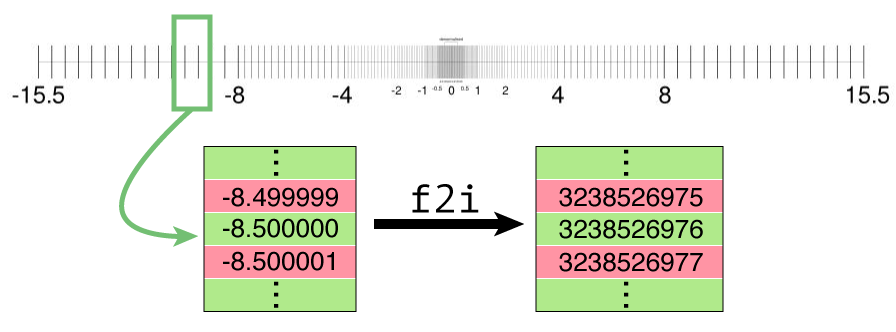

Use this property along with the functions ``f2i`` and ``i2f`` and the aliases ``f16`` etc. defined above to answer the following questions:

1. How many floating point values are located between the values ``1`` and ``2``, including the endpoints? How about ``1001`` and ``1002`` ? Give answers for 16, 32, and 64 bit precision variants. <br><br>

2. How large is 1 ULP for the value $\pi$ expressed in 64 bit arithmetic? Remember that one ULP was defined as the jump that occurred when changing the last mantissa bit from a ``1`` to a ``0`` (or vice versa).<br><br>

3. Suppose that we compute the surface area of the earth from its radius of $\approx 6.353\cdot 10^6m$ using the expression $A=4\pi r^2$. Assuming that the earth is perfectly spherical, and that the discretization of $\pi$ is the only source of error in this computation, bound the absolute error in square meters.

In [963]:
## Solution

## Helper functions

##################################################################
# To compute the number of floating poiunt values located between #
# two values 'a' and 'b', including the endpoints.                #
###################################################################
def get_number_of_floating_point_values(a, b, precision):
    float_to_int_interval = np.zeros(2) # initialize a default array to store the int values
    # convert 'a' and 'b' in the wanted precision and then apply the function f2i on the array
    # only have to calculate the difference of the two integers in the resulting array and add 1
    if precision == 16:
        float_to_int_interval = f2i(np.array([a,b], dtype=f16)) 
    elif precision == 32:
        float_to_int_interval = f2i(np.array([a,b], dtype=f32)) 
    else:
        float_to_int_interval = f2i(np.array([a,b], dtype=f64)) 
    
    return abs(float_to_int_interval[1] - float_to_int_interval[0]) + 1 # +1 to count the last element

####################################################################
# Function that computes the absolute error between the true value #
# and the measured one.                                            #
####################################################################
def get_absolute_error(true_val, measured_val):
    return abs(true_val - measured_val)

####################################################################
# Function that computes the relative error between the true value #
# and the measured one.                                            #
####################################################################
def get_relative_error(true_val, measured_val):
    return get_absolute_error(true_val, measured_val) / true_val

###################################################################
# Function that computes the surface of a sphere where 'r' is the #
# radius and 'discretized_pi' is a value of pi.                   #
###################################################################
def compute_sphere_surface(r, discretized_pi):
    return 4*discretized_pi*(r**2)




## Answers (please run the cell to print the answers correctly)

## Question 3.1
BITS = [16, 32, 64]

print("Question 3.1:\n", "  ", 
      "The number of floating point values between 1 and 2 is :")
for i in BITS:
    print("     ", "- for a", i, "bits precision:", get_number_of_floating_point_values(1,2,i))
    
print("\n   ", "The number of floating point values between 1001 and 1002 is :")
for i in BITS:
    print("     ", "- for a", i, "bits precision:", get_number_of_floating_point_values(1001,1002,i))

## Question 3.2
num = f64(np.pi) # first we convert np.pi into a float 64

next_int = f2i(num)+ u64(1) # now changing the last mantissa bit of the floating point 
                            # value of 'num' is equivalent to adding one to its
                            # integer representation by continuity
# now all we need to do is to convert 'next_int' to a float, and do a substraction 
# to get the value of 1 ULP
ulp = abs(num - i2f(next_int))
print("\n\n", "Question 3.2:\n", "  ",
      "One ULP for the value 𝜋 expressed in 64 bit arithmetic is:", ulp, "\n\n")


## Question 3.3
# We have the value of 𝜋 expressed in 64 bit arithmetic, and the value of 1 ULP for this 𝜋.
# However, the real value of 𝜋 (i.e. the non-discretized one) is between the float right 
# before and the float right after 𝜋 expressed in 64 bit arithmetic, in other words the real 
# 𝜋 belongs to the interval ]f64(𝜋) - 1-ULP ; f64(𝜋) + 1-ULP [.
# Hence we calculate the surface area with discretized_pi = f64(np.pi) and then with 
# discretized_pi = f64(np.pi)+1-ULP. After we use the two freshy computed surface to get the
# absolute error.

closest_earth_area = compute_sphere_surface(6.353e6, f64(np.pi))
furthest_earth_area = compute_sphere_surface(6.353e6, f64(np.pi) + ulp)
print("Question 3.3:\n", "  ",
      "The surface area of the earth given its radius of 6.353e6 meters is", 
          closest_earth_area, "square meters,\n that is about 507 millions of square kilometers.\n",
      "Assuming that the earth is perfectly spherical, and that the discretization",
      "of 𝜋 is the only source of \n error in this computation, the absolute error is strictly less than",
      get_absolute_error(closest_earth_area, furthest_earth_area), "square meters.")

Question 3.1:
    The number of floating point values between 1 and 2 is :
      - for a 16 bits precision: 1025
      - for a 32 bits precision: 8388609
      - for a 64 bits precision: 4503599627370497.0

    The number of floating point values between 1001 and 1002 is :
      - for a 16 bits precision: 3
      - for a 32 bits precision: 16385
      - for a 64 bits precision: 8796093022209.0


 Question 3.2:
    One ULP for the value 𝜋 expressed in 64 bit arithmetic is: 4.440892098500626e-16 


Question 3.3:
    The surface area of the earth given its radius of 6.353e6 meters is 507186370915240.4 square meters,
 that is about 507 millions of square kilometers.
 Assuming that the earth is perfectly spherical, and that the discretization of 𝜋 is the only source of 
 error in this computation, the absolute error is strictly less than 0.0625 square meters.


## Problem 4: Series approximations (25 pts)
-- --

In Lecture 1, we saw how various numerical issues could occur due to the floating point number representation.  
Consider the power series representation of the sine function:

$$
\sin(x)=x-\frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!}+\cdots
$$

**Hint**: the first 20 coefficients of the sine power series representation look like this:

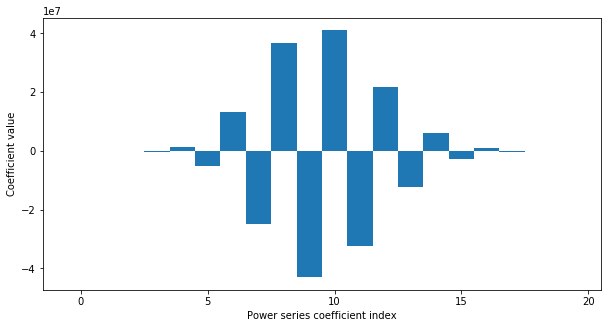

1. Evaluate the power series at \(x=20\) using the first 100 terms and compute the absolute and relative error (you can assume that ``np.sin`` is accurate). *Hint*: the factorial function is provided in ``scipy.special``.<br><br>

2. Express the error as an integer number of ULPs (see also Problem 3) -- in other words, how many floating point numbers are between the true and the approximate answer?<br><br>

3. Now, evaluate the exponential function at ``x=30`` using the same approach: using its corresponding power series, and assuming that ``np.exp`` is accurate. Specify the absolute and relative error. What do you observe compared to the sine power series? Why is this the case?<br><br>

4. List three different kinds of numerical problems that can arise when evaluating the above two power series with very many terms (e.g. thousands), and what parts of the expression specifically cause them.

In [964]:
## Solution
from scipy.special import factorial

## Helper functions

################################################################
# To compute an approximate value of the sinus function        #
# evaluated in 'x' with the 'n' first terms of the power serie #
################################################################
def get_sinus_value(x, n):
    acc = 0
    for k in range(n):
        acc += (-1)**k * x**(2*k+1) / factorial(2*k+1)
    return acc

################################################################
# To compute an approximate value of the exponential function  #
# evaluated in 'x' with the 'n' first terms of the power serie #
################################################################
def get_exponential_value(x, n):
    acc = 0
    for k in range(n):
        acc += x**k / factorial(k)
    return acc



## Answers (please run the cell to print the answers correctly)

## Question 4.1
sin_20 = get_sinus_value(20, 100)
abs_error_sin = get_absolute_error(np.sin(20), sin_20)
relative_error_sin = get_relative_error(np.sin(20), sin_20)
print("Question 4.1:\n", "  ", 
      "The value of sin(x=20) using the 100 first terms of the power series is:", sin_20, "\n",
      "Assuming np.sin is accurate:\n",
      "   ", "- the absolute error is:", abs_error_sin, "\n",
      "   ", "- the relative error is:", relative_error_sin, "\n\n")

## Question 4.3
# The process is similar to problem 3.1, we reuse get_number_of_floating_point_values
print("Question 4.2:\n", "  ", 
      "The error as an integer number of ULPs for the sine function is:", 
      get_number_of_floating_point_values(np.sin(20), sin_20, 64), "\n\n")

exp_30 = get_exponential_value(30, 100)
abs_error_exp = get_absolute_error(np.exp(30), exp_30)
relative_error_exp = get_relative_error(np.exp(30), exp_30)
print("Question 4.3:\n", "  ", 
      "The value of exp(x=30) using the 100 first terms of the power series is:", exp_30, "\n",
      "Assuming np.exp is accurate:\n",
      "   ", "- the absolute error is:", abs_error_exp, "\n",
      "   ", "- the relative error is:", relative_error_exp)
print("Compared to the sine power series, the exponential power series has a way bigger absolute error,\n",
      "but the relative error is really smaller. It is due to the fact that the exponential function\n",
      "takes values that are very big (while sine is very small between -1 and 1), and hence because of\n"
      "the floating point representation, it has to be less precise to represent the number.\n",
      "We can indeed calculate the number of ULPs between the real and measured value and see how small it is.")
print("The error as an integer number of ULPs for the exponential function is:", 
      get_number_of_floating_point_values(np.exp(30), exp_30, 64), "\n\n")

## Question 4.4
print("Question 4.4:\n", "  ", 
     "Three different kinds of numerical problems that can arise when evaluating the above two power series\n",
      "with very many terms are:\n",
     "    ", "- the problem related to the floating point representation, which can lead to a lack\n",
     "of precision on the numbers involved as previously mentioned;\n",
     "    ", "- the problem related to the finite approximation with the power serie of a continuous\n",
     "model, which can also lead to a lack of precision because only the 'n' first terms of the series\n",
      "can be evaluated;\n",
     "    ", "- the problem related to complexity because of the thousands of terms, which can give\n",
     "rise to memory (with the factorial part especially) and/or time issue (with the for loop).")

Question 4.1:
    The value of sin(x=20) using the 100 first terms of the power series is: 0.9129452562745278 
 Assuming np.sin is accurate:
     - the absolute error is: 5.546900161412793e-09 
     - the relative error is: 6.075830020466015e-09 


Question 4.2:
    The error as an integer number of ULPs for the sine function is: 49962036.0 


Question 4.3:
    The value of exp(x=30) using the 100 first terms of the power series is: 10686474581524.467 
 Assuming np.exp is accurate:
     - the absolute error is: 0.00390625 
     - the relative error is: 3.655321472203193e-16
Compared to the sine power series, the exponential power series has a way bigger absolute error,
 but the relative error is really smaller. It is due to the fact that the exponential function
 takes values that are very big (while sine is very small between -1 and 1), and hence because of
the floating point representation, it has to be less precise to represent the number.
 We can indeed calculate the number of ULPs